# Models
In this notebook we explore a few regression approaches, from more explainable models to models with higher predictive power a priori.

In [1]:
%load_ext autoreload
%autoreload 2
from utils import read_data, logit, expit, to_expit
import warnings
import numpy as np

from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score

# import mlflow
# mlflow.set_tracking_uri('localhost:5000')
warnings.simplefilter(action='ignore', category=FutureWarning) # ignore annoying and harmless FutureWarnings

In [2]:
# Helper scorers
neg_mean_squared_error_expit_scorer = make_scorer(to_expit(mean_squared_error), greater_is_better=False)
neg_median_absolute_error_expit_scorer = make_scorer(to_expit(median_absolute_error), greater_is_better=False)
r2_expit_scorer = make_scorer(to_expit(r2_score), greater_is_better=True)


scorers = {
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'neg_median_absolute_error': 'neg_median_absolute_error',
#    'neg_mse': neg_mean_squared_error_expit_scorer,
#    'neg_mae': neg_median_absolute_error_expit_scorer,
    'r2': 'r2'
}

In [3]:
PATH_DATA_FILE = '../data/data.csv'

## 1. Read and prepare data

In [4]:
df = read_data(PATH_DATA_FILE)

# Curate features
features = [c for c in df.columns if 'feat_' in c]

# Features to drop based on the Exploratory Data Analysis (eda.ipynb)
fearures_to_drop_zeros = [
    'feat_03',
    'feat_04',
    'feat_10',
    'feat_12',
    'feat_13',
    'feat_18',
    'feat_24',
    'feat_26',
    'feat_27',
    'feat_31',
    'feat_32',
    'feat_35',
    'feat_37',
    'feat_44',
]

fearures_to_drop_high_corr = [
    'feat_34', # v. feat_06 identical
    'feat_36', # v. feat_19
    'feat_38', # v. feat_36
    #'feat_39', # v. feat_18
]

features_to_drop = fearures_to_drop_zeros + fearures_to_drop_high_corr
features_to_include = [f for f in features if f not in features_to_drop]

In [5]:
# Engineered features
df['feat_sum'] = df[features_to_include].sum(axis=1)
df['feat_zeros'] = (df[features_to_include] == 0).sum(axis=1)
df['feat_above_one'] = (df[features_to_include] > 1).sum(axis=1)
features_to_include += ['feat_sum', 'feat_zeros', 'feat_above_one']

In [6]:
# Define target variable

df['rate'] = df['submissions'] / df['views']

In [7]:
X = df[features_to_include]
y = df['rate']
y_logit = logit(df['rate'])

/Users/yc00055/dev/tfcc/prototyping/utils.py:43: RuntimeWarning: divide by zero encountered in log
  return np.clip(np.log(y / (1 - y)) / (1 + np.exp(-y)), -cap, cap)


## 2. Classic regression approach: Fractional Logistic Regression
The dataset provided consists of a set of features (indep. vars) plus a target variable (dep. var). The dependent variable in this case is a rate (percentage). Hence, one of the natural ways of modelling it is by means of a fractional outcome model such as a fractional Logistic Regression.

In [8]:
import statsmodels.api as sm
from sklearn.base import BaseEstimator, RegressorMixin

# taken from: https://stackoverflow.com/a/48949667
class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [9]:
# Fitting all data with MLE Logit
flr_model = sm.Logit(y, X)

flr_results = flr_model.fit()

flr_results.summary()

Optimization terminated successfully.
         Current function value: 0.679981
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   rate   No. Observations:              1031284
Model:                          Logit   Df Residuals:                  1031252
Method:                           MLE   Df Model:                           31
Date:                Thu, 11 Jul 2019   Pseudo R-squ.:                 0.01584
Time:                        02:03:53   Log-Likelihood:            -7.0125e+05
converged:                       True   LL-Null:                   -7.1254e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
feat_01            0.2223   1325.913      0.000      1.000   -2598.519    2598.964
feat_02            0.0239   1325.913    1.8e-05      1.000   -2598.717    2598.765
feat_05            0.2070   1325.913      0.000      1.000   -2598.534    2598.948
feat_06            0.1121   1325.913   8.45e-05      1.000   -2598.629    2598.853
feat_07            0.1041   1325.913   7.85e-05      1.000   -2598.637    2598.845
feat_08           -0.2372   1325.913     -0.000      1.000   -2598.978    2598.504
feat_09           -0.0237   1325.913  -1.78e-05      1.000   -2598.765    2598.718
feat_11            0.0593   1325.913   4.47e-05      1.000   -2598.682    2598.801
feat_14            0.1149   1325.913   8.67e-05      1.000   -2598.626    2598.856
feat_15           -0.4915   1325.913     -0.000      1.000   -2599.233    2598.250
feat_16            0.0373   1325.913   2.81e-05      1.000   -2598.704    2598.779
feat_17            0.0135   1325.913   1.02e-05      1.000   -2598.728    2598.755
feat_19            0.0874   1325.913   6.59e-05      1.000   -2598.654    2598.829
feat_20           -0.6848   1325.913     -0.001      1.000   -2599.426    2598.056
feat_21            0.0102   1325.913   7.66e-06      1.000   -2598.731    2598.751
feat_22            0.0040   1325.913   3.03e-06      1.000   -2598.737    2598.745
feat_23            0.0209   1325.913   1.58e-05      1.000   -2598.720    2598.762
feat_25            0.0317   1325.913   2.39e-05      1.000   -2598.710    2598.773
feat_28            0.0067   1325.913   5.02e-06      1.000   -2598.735    2598.748
feat_29            0.0220   1325.913   1.66e-05      1.000   -2598.719    2598.763
feat_30            0.0413   1325.913   3.11e-05      1.000   -2598.700    2598.783
feat_33            0.0793   1325.913   5.98e-05      1.000   -2598.662    2598.821
feat_39            0.0754   1325.913   5.69e-05      1.000   -2598.666    2598.817
feat_40            0.0385   1325.913    2.9e-05      1.000   -2598.703    2598.780
feat_41            0.0192   1325.913   1.45e-05      1.000   -2598.722    2598.760
feat_42           -0.0018   1325.913  -1.33e-06      1.000   -2598.743    2598.740
feat_43           -0.0587   1325.913  -4.43e-05      1.000   -2598.800    2598.683
feat_45            0.0472   1325.913   3.56e-05      1.000   -2598.694    2598.789
feat_46            0.0380   1325.913   2.87e-05      1.000   -2598.703    2598.779
feat_47            0.0412   1325.913   3.11e-05      1.000   -2598.700    2598.782
feat_sum          -0.0403   1325.913  -3.04e-05      1.000   -2598.782    2598.701
feat_zeros         0.0056      0.000     44.195      0.000       0.005       0.006
feat_above_one     0.0188      0.001     16.344      0.000       0.017       0.021
==================================================================================
"""

In [10]:
# Cross validation
# Note: removed support for MLFlow due to lack of time
# exp_id = mlflow.create_experiment('tfcc/fractional_log_reg2')

xval_results = cross_validate(SMWrapper(sm.Logit), X, y, cv=5,
                scoring=scorers)

xval_results
# for score in scorers:
#     score_mean = xval_results[f'test_{score}'].mean()
#     score_std = xval_results[f'test_{score}'].std()
#    with mlflow.start_run(experiment_id=exp_id):
#        mlflow.log_metric(f'xval_{score}_mean', score_mean)
#        mlflow.log_metric(f'xval_{score}_std', score_std)

Optimization terminated successfully.
         Current function value: 0.679890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680005
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.679963
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679958
         Iterations 6


{'fit_time': array([3.631253  , 3.72383189, 3.49594092, 3.66637015, 4.45248508]),
 'score_time': array([0.54276824, 0.40694404, 0.393718  , 0.44823694, 0.40577197]),
 'test_neg_mean_squared_error': array([-0.04631834, -0.04621984, -0.04634721, -0.04630702, -0.04624102]),
 'test_neg_median_absolute_error': array([-0.15713446, -0.15736959, -0.15723726, -0.15703716, -0.1569948 ]),
 'test_r2': array([0.07088219, 0.07286294, 0.07248053, 0.07220985, 0.07210821])}

According to the above fit, none of the input variables are significant in a MLE fractional log reg setting. 
We've also attempted at doing weighted regression using the views and submission values without success. Furthermore, the cross-validation results are not very encouraging
Hence, he might need to turn our attention to models with more predictive power at the cost of lower explainability.

## 3. Machine Learning approach - eXtreme Gradient Boosting

In this section we explore a couple of ML regression models. We resort on the ML framework sklearn and xgboost.

In [11]:
from xgboost import XGBRegressor

In [12]:
# We are using reg:linear instead of reg:squarederror for backwards compatibility with the service, 
# which uses xgboost=0.82

xgb_model = XGBRegressor(
    eta=0.3,
    max_depth=6,
    min_child_weight=1,
    objective='reg:linear',
    nthread=-1, 
    missing=None)

In [13]:
%%time
# Fitting XGBoost regressor with all data
xgb_model.fit(X, y)
y_pred = xgb_model.predict(X)

r2_score(y, y_pred)

[02:06:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 3min 51s, sys: 2.02 s, total: 3min 53s
Wall time: 3min 58s


0.12537033280171728

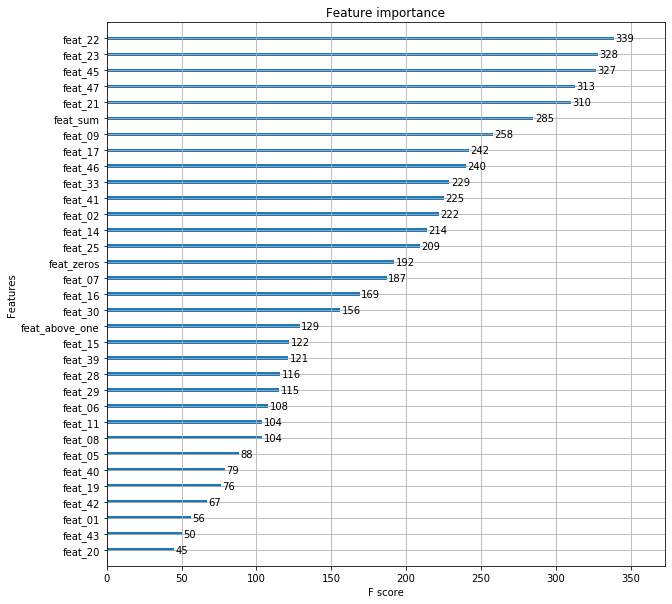

In [16]:
%matplotlib inline
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_importance(xgb_model,ax=ax)

In [17]:
# Cross validation
#exp_id = mlflow.create_experiment('tfcc/fractional_log_reg2')

xval_results = cross_validate(xgb_model, X, y, cv=5,
                scoring=scorers)

xval_results
# for score in scorers:
#     score_mean = xval_results[f'test_{score}'].mean()
#     score_std = xval_results[f'test_{score}'].std()
#    with mlflow.start_run(experiment_id=exp_id):
#        mlflow.log_metric(f'xval_{score}_mean', score_mean)
#        mlflow.log_metric(f'xval_{score}_std', score_std)

[02:19:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:23:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:26:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:29:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:33:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'fit_time': array([195.22553015, 197.88711023, 189.29312825, 188.91623306,
        222.41177177]),
 'score_time': array([2.83517599, 2.87595296, 3.26344299, 3.04527473, 2.70556808]),
 'test_neg_mean_squared_error': array([-0.04388621, -0.04375189, -0.04396022, -0.04386802, -0.04377609]),
 'test_neg_median_absolute_error': array([-0.1506158 , -0.15069154, -0.15126281, -0.15053455, -0.15078774]),
 'test_r2': array([0.11966939, 0.12236832, 0.12025   , 0.12107684, 0.12157065])}